In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
# import LSTM_Train as LSTM
import importlib
import LSTM
import Dense
importlib.reload(LSTM)
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats


In [2]:
FillVar = 'fch4'
Runs,params = Dense.Params('Test',FillVar,MP=False)# rpms.Runs,rpms.params
Runs['MSE'] = 0.0
Runs['STD'] = 0.0
Runs['CI'] = 0.0
print(Runs)

    N  MSE  STD   CI
0  70  0.0  0.0  0.0
1   6  0.0  0.0  0.0
2  10  0.0  0.0  0.0


Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finisehed Run  0
Finisehed Run  1
Finisehed Run  2


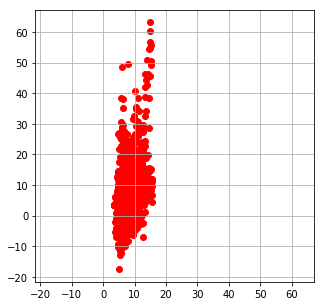

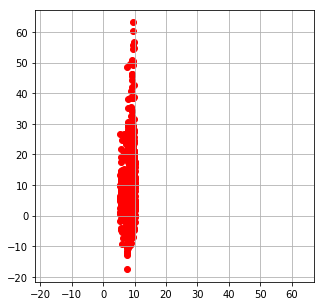

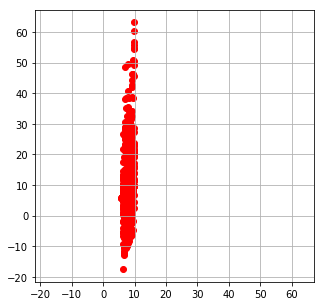

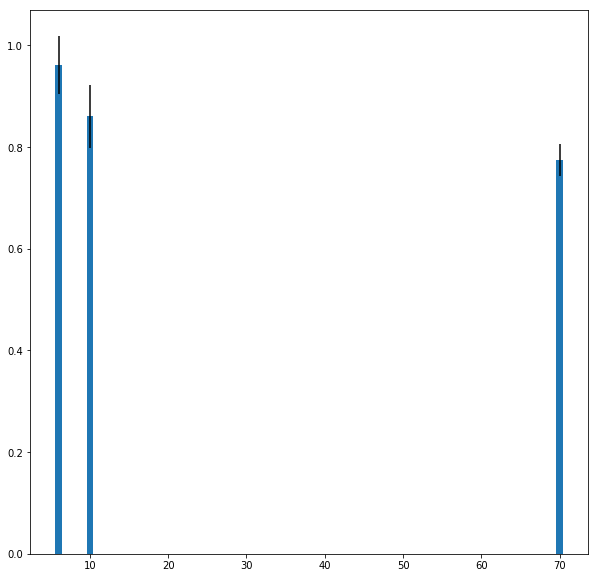

In [3]:

def TTV_Split(i,Memory,X,y,params,X_fill):
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=i)
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=i)
    return(Dense.Train_Steps(params['epochs'],params['N'],X_train,X_test,X_val,y_train,y_test,
                            y_val,i,X_fill = X_fill,Memory=Memory))


AllVars = ['H','LE','Fco2','fco2','fch4','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table','Ts 2.5 cm',
         'Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd','ET']

# FullModel = ['Wind Spd','air pressure','Ta','PPFD','Ts 2.5 cm','Ts 15 cm',
#          'VWC','Active Layer','Rain','Water Table']


FullModel = ['wind_speed','Sedge','Shrub','PPFD_Avg','Temp']

Time = time.time()
Path = 'C:/Users/wesle/Illisarvik_Processing/Data_Footprints_2018-05-06.csv'#'Data_Footprints_2018-05-04.csv'

def RunReps(Model,params,pool = None,plot=False,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(Path)
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y.copy()#*1.0
    X = RST.X.copy()#*1.0
    X_fill = RST.X_fill.copy()
#     y = RST.y_time.copy()#*1.0
#     X = RST.X_time.copy()#*1.0
#     X_fill = RST.X_ftime.copy()
    MSE = []
    STD = []
    Y_fill = []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),
                                             range(params['reps']))):
            mse = results[0]
            y_fill = results[1]
            Y_fill.append(y_fill)
            MSE.append(mse)
    else:
        for i in range(params['reps']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            mse = results[0]
            MSE.append(mse)
            y_fill = results[1]
            Y_fill.append(y_fill)
    MSE = np.asanyarray(MSE)
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0)
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
    if plot == True:
#         plt.figure(figsize=(5,5))
#         plt.plot(RST.Master[FillVarName],color='red')
#         plt.plot(RST.Master[FillVar],color='blue',alpha=.5)  # This works
#         yl = plt.ylim()
#         plt.grid()
        
        plt.figure(figsize=(5,5))
        plt.scatter(RST.Master['TempFill'],RST.Master[FillVarName],color='red')
        yl = plt.ylim()
        plt.xlim(yl)
        plt.grid()
        
    if FullReturn == False:
        return(MSE,RST.Master['TempFill'])
    else:
        return(MSE,RST.Master)

if __name__=='__main__'and params['proc'] != 1:
    pool = Pool(processes=params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Runs.index:
    try:
        params['T']=Runs['T'].iloc[i]
    except:
        params['T'] = 0
    params['N']=Runs['N'].iloc[i]
    Results = RunReps(FullModel,params,pool,plot=True)
    MSE = Results[0]
    Runs['MSE'][i]=MSE.mean()
    Runs['STD'][i]=MSE.std()
    print('Finisehed Run ',str(i))

Runs['CI'] = Runs['STD']/params['reps']**.5*1.96
try:
    plt.figure(figsize=(10,10))
    plt.scatter(Runs['N'],Runs['T'],c = Runs['MSE'],s=Runs['STD']*1e4)
except:
    plt.figure(figsize=(10,10))
    plt.bar(Runs['N'],Runs['MSE'],yerr=Runs['CI'])
    

In [4]:


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=-1.0):
    return mu_x + kappa * sigma_x


# kernel = Matern()#length_scale = [1,1],length_scale_bounds="fixed")
# kernel = ConstantKernel(1e0, (1e-2, 1e2))*Matern(1e1, (1e-4, 1e4),nu = 2.5)\
# + WhiteKernel(noise_level=1e0, noise_level_bounds=(1e-2, 1e2))
acq = upper_confidence_bound
def query(xi, yi, gp):
    best_value = np.inf
    for N in np.linspace(1,params['N_Max']):
        if params['T']>0:
            for T in np.linspace(0,params['T_Max']):
                def obj(x):
                    x=x.reshape(1,-1)
                    mu_x, sigma_x = gp.predict(x, return_std=True)
                    return acq(mu_x, sigma_x, np.min(yi))
                x0 = np.asanyarray([N,T]).reshape(1,2)
                bounds=((1, params['N_Max']),(0,params['T_Max']))
                print(x0,bounds)
                res = minimize(obj, x0, bounds=bounds)

                if res.fun < best_value:
                    best_value = res.fun
                    query_point = res.x
        else:
            def obj(x):
                x=x.reshape(1,-1)
                mu_x, sigma_x = gp.predict(x, return_std=True)
                return acq(mu_x, sigma_x, np.min(yi))
            x0 = np.asanyarray(N).reshape(1,-1)
            bounds=[(1, params['N_Max'])]
            res = minimize(obj, x0, bounds=bounds)
            if res.fun < best_value:
                best_value = res.fun
                query_point = res.x
    query_point = query_point
    return query_point


params['T']=0
for i in range(params['Searches']):
    kernel = Matern(length_scale_bounds="fixed") 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=Runs['STD'].values, random_state=1,normalize_y=True)
    if params['T']>0:
        gp.fit(Runs[['N','T']].values, Runs['MSE'].values)
        next_x = query(Runs[['N','T']].values, Runs['MSE'].values, gp)
        N = int(np.round(next_x[0],0))
        T = int(np.round(next_x[1],0))
        o = 0
        while len(Runs.loc[(Runs['N']==N) & (Runs['T']==T)].index) != 0:
            print('Adjust!')
            o +=1
            N += int(o*np.cos(o*np.pi))
            if N < params['N_Min'] or N > params['N_Max']:
                N -= int(o*np.cos(o*np.pi))
            if o > 5:
                T += 1
        print(N,T)
        d = {'N':N,'T':T,'MSE':0,'STD':0}
        idx = Runs.index[-1] + 1
        D2 = pd.DataFrame(data=d,index=[idx])
        Runs = Runs.append(D2)
        params['T'] = T
        params['N'] = N
        Results = RunReps(FullModel,params,pool)
        MSE = Results[0]
        Runs['MSE'][idx]=MSE.mean()
        Runs['STD'][idx]=MSE.std()
        Runs = Runs.sort_values(by = ['N','T']).reset_index(drop=True)
    else:
        gp.fit(Runs['N'].values.reshape(-1,1), Runs['MSE'].values)
        next_x = query(Runs['N'].values, Runs['MSE'].values, gp)
        N = int(np.round(next_x[0],0))
        o = 0
        while len(Runs.loc[Runs['N']==N].index) != 0:
            print('Adjust!')
            o +=1
            N += int(o*np.cos(o*np.pi))
            if N < params['N_Min'] or N > params['N_Max']:
                N -= int(o*np.cos(o*np.pi))
        print(N)
        d = {'N':N,'MSE':0,'STD':0}
        idx = Runs.index[-1] + 1
        D2 = pd.DataFrame(data=d,index=[idx])
        Runs = Runs.append(D2)
        params['N'] = N
        Results = RunReps(FullModel,params,pool)
        MSE = Results[0]
        Runs['MSE'][idx]=MSE.mean()
        Runs['STD'][idx]=MSE.std()
        Runs = Runs.sort_values(by = ['N']).reset_index(drop=True)
        

# plt.scatter(Runs['N'],Runs['T'],c=Runs['MSE'],s=Runs['STD']*1e4)

68


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


65


         CI       MSE   N       STD  Upper_Bounds
0  0.068705  0.960996   6  0.058389      1.029701
1  0.073602  0.860241  10  0.062550      0.933843
2  0.025319  0.781363  65  0.021518      0.806683
3  0.027560  0.769902  68  0.023422      0.797462
4  0.037217  0.774985  70  0.031628      0.812202
Optimum:
3    0.797462
Name: Upper_Bounds, dtype: float64


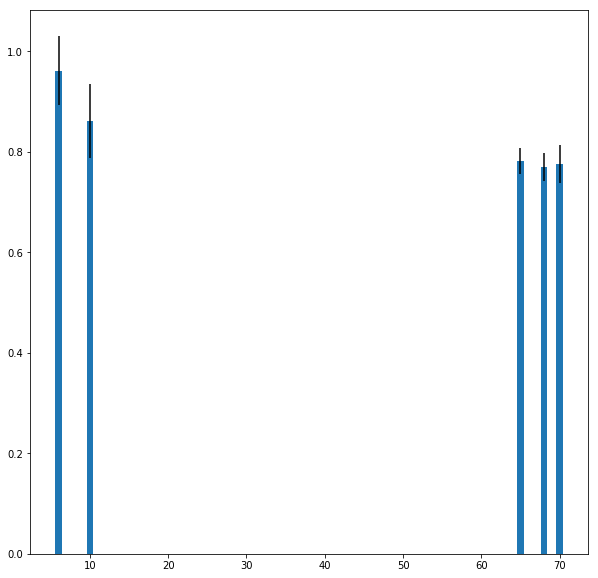

In [5]:
try:
    Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-2)
    Runs['Upper_Bounds'] = Runs['MSE']+Runs['CI']
    plt.figure(figsize=(10,10))
    plt.scatter(Runs['N'],Runs['T'],c = Runs['MSE'],s=Runs['STD']*1e4)
except:
    Runs['CI'] = Runs['STD']/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-1)
    Runs['Upper_Bounds'] = Runs['MSE']+Runs['CI']
    plt.figure(figsize=(10,10))
    plt.bar(Runs['N'],Runs['MSE'],yerr=Runs['CI'])
    

print(Runs)
Optimum = Runs[Runs['Upper_Bounds'] == Runs['Upper_Bounds'].min()]
print('Optimum:')
print(Optimum['Upper_Bounds'])


# Feature Identification

In [10]:
BestMSE = []
BestSTD = []
idx = []
BestModels = []

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    print (Models)
    return(Models)
try:
    params['T']=Optimum['T'].values[0]
except:
    pass
params['N']=Optimum['N'].values[0]
# print(Optimum)

print(FullModel)
Scores = Optimum[['MSE','CI','Upper_Bounds','STD']].reset_index(drop=True)
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)
# print(Scores)
Results = RunReps(FullModel,params,pool)
ModelRuns = Results[1]
ModelRuns = ModelRuns.to_frame()
ModelRuns.rename(columns={'TempFill':'+'.join(FullModel)})
# print(ModelRuns)

for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     Score = []
#     STD = []
#     Model_Names = []
    
    for i,model in enumerate(Models):
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+'+'.join(model)
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        mean,std = MSE.mean(),MSE.std()
        CI = std/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-1)
        level = len(model)
        key = str(level)+'_'+str(i)
        d = {'Model':'+'.join(model),
             'MSE':mean,'STD':std,'Level':level,
             'CI':CI,'Upper_Bounds':mean+std,
                'Key':key}
        score = pd.DataFrame(index=[0],data=d)
        print(model,mean)
        Scores = Scores.append(score,ignore_index=True)
        ModelRuns['Model: '+'+'.join(model)] = Results[1]
        
    Level = Scores.loc[Scores['Level'] == level]
    Lowest_Yet = Scores.loc[Scores['Level']<= level]['Upper_Bounds'].min()
    Best = Level.loc[Level['MSE']<=Lowest_Yet]['Model'].values
    print(ModelRuns)
#         print(model,MSE)
#         Score.append(MSE.mean())
#         STD.append(MSE.std())
#         Model_Names.append('Model: '+'+'.join(model))
        
#     Score = np.asanyarray(Score)
#     STD = np.asanyarray(STD)
#     Best = Models[np.where(Score == Score.min())[0][0]]
#     Best_Name = Model_Names[np.where(Score == Score.min())[0][0]]
#     BestModels.append(Best_Name)
#     BestMSE.append(Score.min())
#     BestSTD.append(STD[np.where(Score == Score.min())[0][0]])
#     idx.append(i)
#     print('Best:')
#     print(Best,Score.min())
# BestModels = np.asanyarray(BestModels)
# BestMSE = np.asanyarray(BestMSE)
# BestSTD = np.asanyarray(BestSTD)
# idx = np.asanyarray(idx)
# BestSE = BestSTD/(params['reps']**.5)
# BestCI = BestSE*1.96
# plt.figure(figsize=(10,10))
# plt.bar(idx,BestMSE)
# plt.errorbar(idx,BestMSE,yerr=BestCI,color = 'black',fmt='o')

# d = {'Models':BestModels,'MSE':BestMSE,'CI':BestCI}
# Stats = pd.DataFrame(index=idx,data=d)
Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
# print(Stats)

ModelRuns.to_csv('GapFilled'+FillVar+'.csv')



['wind_speed', 'Sedge', 'Shrub', 'PPFD_Avg', 'Temp']
Level:  1
[['wind_speed'], ['Sedge'], ['Shrub'], ['PPFD_Avg'], ['Temp']]
['wind_speed'] 0.867153508804
['Sedge'] 0.785163046901
['Shrub'] 0.852889663566
['PPFD_Avg'] 0.857310413713
['Temp'] 0.859743367608
                      TempFill  Model: wind_speed  Model: Sedge  Model: Shrub  \
datetime                                                                        
2016-07-10 16:30:00  10.622921           8.450261      7.178561      9.145177   
2016-07-10 17:00:00  10.522912           8.450261      7.178561      9.145177   
2016-07-10 17:30:00   9.080826           8.450261      7.178561      9.145177   
2016-07-10 18:00:00   8.322776           8.450261      7.178561      9.145177   
2016-07-10 18:30:00   9.836208           8.450261      7.178561      9.145177   
2016-07-10 19:00:00   9.464829           8.450261      7.178561      9.145177   
2016-07-10 19:30:00   9.040360           8.450261      7.178561      9.145177   
2016-07-10 20

['wind_speed', 'Sedge'] 0.781173452196
['Sedge', 'Shrub'] 0.791813813463
['Sedge', 'PPFD_Avg'] 0.779557513868
['Sedge', 'Temp'] 0.786655434059
                      TempFill  Model: wind_speed  Model: Sedge  Model: Shrub  \
datetime                                                                        
2016-07-10 16:30:00  10.622921           8.450261      7.178561      9.145177   
2016-07-10 17:00:00  10.522912           8.450261      7.178561      9.145177   
2016-07-10 17:30:00   9.080826           8.450261      7.178561      9.145177   
2016-07-10 18:00:00   8.322776           8.450261      7.178561      9.145177   
2016-07-10 18:30:00   9.836208           8.450261      7.178561      9.145177   
2016-07-10 19:00:00   9.464829           8.450261      7.178561      9.145177   
2016-07-10 19:30:00   9.040360           8.450261      7.178561      9.145177   
2016-07-10 20:00:00   8.682474           8.450261      7.178561      9.145177   
2016-07-10 20:30:00   8.357462           8.4502

['wind_speed', 'Sedge', 'Shrub'] 0.788408488724
['wind_speed', 'Sedge', 'PPFD_Avg'] 0.773965563767
['wind_speed', 'Sedge', 'Temp'] 0.778457675472
['Sedge', 'Shrub', 'PPFD_Avg'] 0.797473341
['Sedge', 'Shrub', 'Temp'] 0.790711708787
['Sedge', 'PPFD_Avg', 'Temp'] 0.780874723643
                      TempFill  Model: wind_speed  Model: Sedge  Model: Shrub  \
datetime                                                                        
2016-07-10 16:30:00  10.622921           8.450261      7.178561      9.145177   
2016-07-10 17:00:00  10.522912           8.450261      7.178561      9.145177   
2016-07-10 17:30:00   9.080826           8.450261      7.178561      9.145177   
2016-07-10 18:00:00   8.322776           8.450261      7.178561      9.145177   
2016-07-10 18:30:00   9.836208           8.450261      7.178561      9.145177   
2016-07-10 19:00:00   9.464829           8.450261      7.178561      9.145177   
2016-07-10 19:30:00   9.040360           8.450261      7.178561      9.14517

['wind_speed', 'Sedge', 'Shrub', 'PPFD_Avg'] 0.767590855724
['wind_speed', 'Sedge', 'Shrub', 'Temp'] 0.790666695633
['wind_speed', 'Sedge', 'PPFD_Avg', 'Temp'] 0.774997263601
['Sedge', 'Shrub', 'PPFD_Avg', 'Temp'] 0.798182154743
                      TempFill  Model: wind_speed  Model: Sedge  Model: Shrub  \
datetime                                                                        
2016-07-10 16:30:00  10.622921           8.450261      7.178561      9.145177   
2016-07-10 17:00:00  10.522912           8.450261      7.178561      9.145177   
2016-07-10 17:30:00   9.080826           8.450261      7.178561      9.145177   
2016-07-10 18:00:00   8.322776           8.450261      7.178561      9.145177   
2016-07-10 18:30:00   9.836208           8.450261      7.178561      9.145177   
2016-07-10 19:00:00   9.464829           8.450261      7.178561      9.145177   
2016-07-10 19:30:00   9.040360           8.450261      7.178561      9.145177   
2016-07-10 20:00:00   8.682474           8

In [7]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        

303.5292823314667
